In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import requests 

In [2]:
import datetime

In [3]:
import os 
os.chdir('E://bond-dex/bond-amm-research')

## CIR Model

In [4]:
class Rate(): 
    
    def __init__(self, T, N, r0, a, b, sigma): 
        self.T = T
        self.N = N 
        self.r0 = r0 
        self.a = a 
        self.b = b 
        self.sigma = sigma 
        self.dt = T / N
        
    def cir(self): 
        
        out = np.zeros(self.N)
        
        out[0] = r0 
        
        for i in range(self.N - 1):
            dr_i = self.a * (self.b - out[i]) * self.dt + self.sigma * np.sqrt(out[i]) * np.random.normal() * np.sqrt(self.dt)
            out[i + 1] = out[i] + dr_i
        
        return out

In [51]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [52]:
T = 1/365
N = int(T * 365 * 24 * 60)

sigma=0.1
a=5
b=0.05

r0 = 0.05

x0 = 0.53

In [53]:
rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)

r = rate.cir()

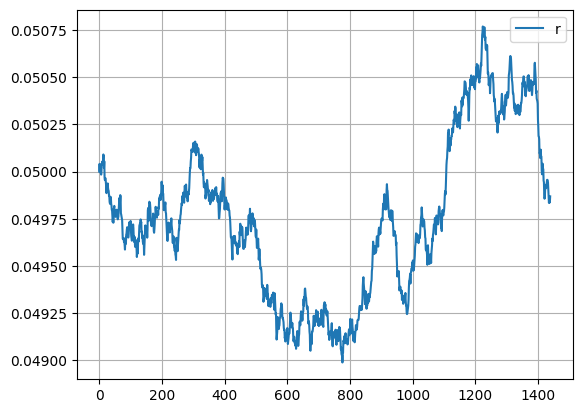

In [54]:
plt.plot(r, label='r')

plt.grid()

plt.legend()

In [9]:
from tqdm import tqdm

In [10]:
negative_rates = []
positive_rates = []
flat_rates = []

for _ in tqdm(range(3000)): 
    while True: 
        rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)
        r = rate.cir()
        if (r.max() - r.min()) < 2 * abs(r[-1] - r[0]):
            break
    if abs(r[-1] - r[0]) < 0.0001: 
        flat_rates.append(r)
    elif r[-1] > r[0]: 
        positive_rates.append(r)
    else: 
        negative_rates.append(r)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:10<00:00, 42.44it/s]


In [11]:
negative_rates = np.array(negative_rates)
positive_rates = np.array(positive_rates)
flat_rates = np.array(flat_rates)

In [12]:
negative_rates.shape, positive_rates.shape, flat_rates.shape

((1506, 1440), (1494, 1440), (0,))

## Simulate rate 

In [16]:
def scale_rate(a, b, rate):
    r0 = rate[0]
    r1 = rate[-1]
    new_rate = (rate - r0)/(r1-r0) * (b - a) + a
    return new_rate

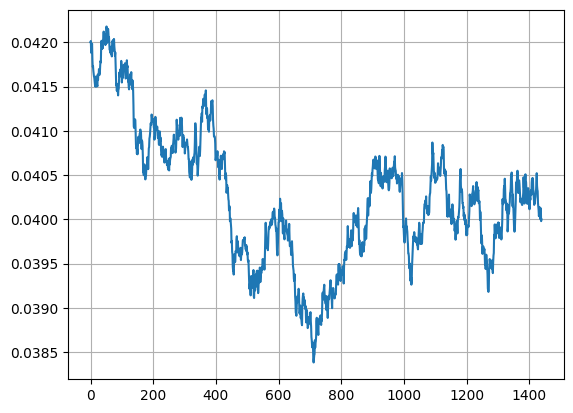

In [17]:
plt.plot(scale_rate(0.042, 0.04, negative_rates[0]))
plt.grid()

## AAVE ETH stable rate

In [16]:
from_date = datetime.datetime(2022, 1, 1).timestamp()
to_date = datetime.datetime(2023, 9, 1).timestamp()

url = f'https://aave-api-v2.aave.com/data/rates-history?reserveId=0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc20xB53C1a33016B2DC2fF3653530bfF1848a515c8c5&from={from_date}&to={to_date}&resolutionInHours=24'

In [17]:
response = requests.get(url)

In [18]:
df = pd.DataFrame(response.json())

In [19]:
df['trans_date'] = df.x.apply(lambda x: datetime.datetime(x['year'], x['month'] + 1, x['date']))

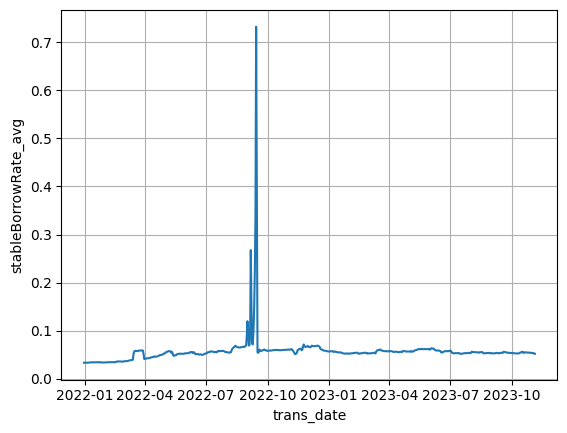

In [20]:
sns.lineplot(data=df, x='trans_date', y='stableBorrowRate_avg')

plt.grid()

In [18]:
df = pd.read_csv('data/input/interest_rate/avve_eth_stable_rate.csv')

## Fit rate to data

In [66]:
T = 1 * 365 * 60 * 24

In [95]:
daily_r = df.query('trans_date >= "2022-07-01"').stableBorrowRate_avg.values

In [96]:
daily_r.shape

(492,)

In [97]:
minute_r = []

for i in range(len(daily_r) - 1): 
    r1 = daily_r[i]
    r2 = daily_r[i+1]
    
    if r2 > r1: 
        random_rate = positive_rates[np.random.choice(len(positive_rates), size=1)[0]]
    else: 
        random_rate = negative_rates[np.random.choice(len(negative_rates), size=1)[0]]
        
    new_r = scale_rate(r1, r2, random_rate)
    
    if min(new_r) < 0:
        print(i)
        print(new_r)
    
    minute_r.extend(new_r[1:])

In [98]:
min_m = max(0.001, min(minute_r))
max_m = max(minute_r)

In [99]:
minute_r = (np.array(minute_r) - min(minute_r)) / (max_m - min(minute_r)) * (max_m - min_m) + min_m

In [102]:
minute_r.shape

(706549,)

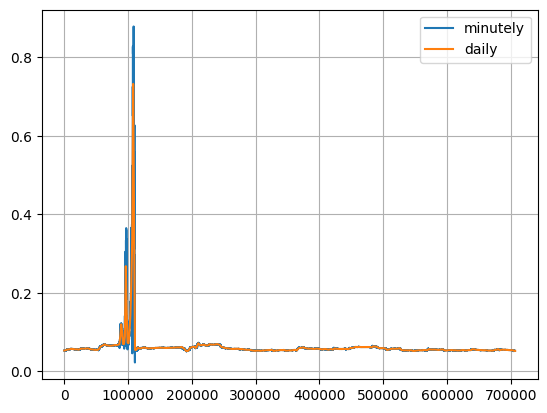

In [103]:
fig, ax = plt.subplots()

ax.plot(minute_r, label='minutely')

ax.plot(np.arange(len(daily_r)) * 24 * 60,daily_r, label='daily')

plt.legend()

plt.grid()

In [104]:
rate_df = pd.DataFrame({'timestamp': range(len(minute_r)), 'rate': minute_r})

In [105]:
rate_df.to_csv('data/input/interest_rate/eth_simulated_rate2.csv', index=False)

In [106]:
rate_df = pd.read_csv('data/input/interest_rate/eth_simulated_rate2.csv')

In [107]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [108]:
T = 1
N = int(T * 365 * 24 * 60)

sigma=0.1
a=5
b=0.05

r0 = 0.05

x0 = 0.53
y0 = 0.5

In [109]:
r = rate_df.rate.values[:N]

In [110]:
r_min = np.quantile(r, 0.001)
r_max = np.quantile(r, 0.999)

In [111]:
r_min, r_max

(0.05130447917255321, 0.7187344090554093)

In [112]:
A = y0 / calculate_y(r0, r_min, r_max, A=1, t=0, T=T)

In [113]:
x = calculate_x(r, r_min, r_max, A=A, t=np.arange(0, N) * T / N, T=T)
y = calculate_y(r, r_min, r_max, A=A, t=np.arange(0, N) * T / N, T=T)

In [114]:
def calculate_x_approx(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y_approx(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [115]:
## the initial state

y0 = y[0] 
r0 = r[0]
T = 1
N = 365 * 24 * 60

r_min = r_min 
r_max = r_max

$$
    y = A \times (r_{max} - r) \times e^{-\frac{(r_{max} - r)^2}{2(r_{max} - r_{min})}\tau - r\tau}
$$

In [116]:
## get A and x0

A = y0 / calculate_y_approx(r0, r_min, r_max, 1, 0, T)

print(f'initial A: {A}')

x0 = calculate_x_approx(r0, r_min, r_max, A, 0, T)

print(f'initial x: {x0}')

initial A: 1.0988254459871276
initial x: 0.0011621790944680163


<font color='red'>**Sample trades over time**</font>

In [117]:
dx = np.diff(x)
dy = np.diff(y)

In [118]:
def sample_trade(dx, dy):
    N = len(dx)
    
    trade_side = np.random.binomial(n=1, p=0.5, size=N)
    
    trade_size = np.where(trade_side == 1, dy, dx)
    
    return trade_side, trade_size

In [119]:
trade_sides, trade_volumes = sample_trade(dx, dy)

### Save simulated trade to csv

In [120]:
trade_df = pd.DataFrame({'dx': dx, 'dy': dy})
trade_df['action'] = trade_df.dy.apply(lambda x: 'lend' if x > 0 else 'borrow')
trade_df = trade_df.reset_index().rename(columns={'dy': 'cash_volume', 'index': 'timestamp'})[['timestamp', 'action', 'cash_volume']]
trade_df.cash_volume = np.abs(trade_df.cash_volume)
trade_df.timestamp += 1

In [121]:
trade_df.groupby('action').agg({'cash_volume': 'describe'})

cash_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    230127.0  0.000111  0.000859  5.114464e-12  0.000002  0.000005   
lend      295472.0  0.000087  0.000763  1.321099e-11  0.000001  0.000004   

                            
             75%       max  
action                      
borrow  0.000014  0.033968  
lend    0.000011  0.031769

In [123]:
trade_df.to_csv('data/input/simulated_eth_trade2.csv', index=False)

In [122]:
r_min, r_max

(0.05130447917255321, 0.7187344090554093)

In [40]:
orders = pd.read_csv('data/input/simulated_eth_trade.csv')

In [41]:
orders.groupby('action').agg({'cash_volume': 'describe'})

cash_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    262292.0  0.000680  0.001531  1.137810e-09  0.000074  0.000228   
lend      263307.0  0.000679  0.001504  2.730427e-10  0.000073  0.000227   

                            
             75%       max  
action                      
borrow  0.000642  0.048553  
lend    0.000650  0.045800